<a href="https://colab.research.google.com/github/aman-welzin/credzin/blob/main/rag/CRAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q -U langchain langchain-community gradio pymupdf python-docx ollama langchain-huggingface newspaper3k lxml-html-clean pillow langgraph langchain_qdrant qdrant-client

# Install Ollama and CUDA drivers
import os
!nvidia-smi
!curl https://ollama.ai/install.sh | sh
!echo 'debconf debconf/frontend select Noninteractive' | sudo debconf-set-selections
!sudo apt-get update && sudo apt-get install -y cuda-drivers
# Set LD_LIBRARY_PATH so the system NVIDIA library
os.environ.update({'LD_LIBRARY_PATH': '/usr/lib64-nvidia'})

!nohup ollama serve &
!ollama ps
# !ollama pull mistral-small3.1
!ollama pull llama3.2
!ollama list

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 50.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 723.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 73.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.0/54.0 MB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.7/322.7 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 63.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.1/211.1 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.2/148.2 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 327.7/327.7 kB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!pip install --upgrade --force-reinstall numpy pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 109.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 112.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.9/229.9 kB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 509.2/509.2 kB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.8/347.8 kB 31.0 MB/s eta 0:00:00
  Attempting uninstall: pytz
    Found existing installation: pytz 2025.2
    Uninstalling pytz-2025.2:
      Successfully uninstalled pytz-2025.2
  Attempting uninstall: tzdata
    Found existing installation: tzdata 2025.2
    Uninstalling tzdata-2025.2:
      Successfully uninstalled tzdata-2025.2
  Attempting uninstall: six
    Found existing installation: six 1.17.0
    Uninstalling six-1.17.0:
      Successfully uninstalled six

In [2]:
import io
import os, uuid
from datetime import datetime
import pandas as pd
from tqdm.notebook import tqdm
import json
import re
import urllib
import pprint
from IPython import embed
import matplotlib.font_manager
import matplotlib as mpl
import newspaper
from newspaper import Config
import sqlite3
import codecs
import base64
import PIL
from PIL import Image, ImageFont, ImageDraw, ImageColor
import textwrap
from IPython.display import Image, display

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.chunk import ne_chunk
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_huggingface import HuggingFaceEmbeddings
from langchain.chains import RetrievalQA
from langchain_community.llms import Ollama
from langchain_core.prompts import ChatPromptTemplate
from langchain import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.messages import AIMessage, HumanMessage
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain.schema import Document
from langchain.docstore import InMemoryDocstore
from langchain.retrievers import ParentDocumentRetriever
from google.colab import userdata
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams
from langgraph.graph.message import add_messages
from langgraph.graph import END, StateGraph, START

from typing import List
from typing_extensions import TypedDict, Annotated

from pydantic import BaseModel, Field

import time
import threading
from concurrent.futures import ThreadPoolExecutor, as_completed
from google.colab import drive
import warnings
warnings.filterwarnings('ignore')

In [3]:
EMBEDDING_MODEL = "sentence-transformers/static-retrieval-mrl-en-v1"
LLAMA_MODEL = "llama3.2"

In [4]:
drive.mount('/content/drive')

DB_PATH = '/content/drive/Shareddrives/Welzin/Yana/YanaNewsProd.db'

conn = sqlite3.connect(DB_PATH)
cursor = conn.cursor()
conn    = sqlite3.connect(DB_PATH)

Mounted at /content/drive


In [5]:
from langchain_qdrant import FastEmbedSparse, QdrantVectorStore, RetrievalMode
from qdrant_client import QdrantClient, models
from qdrant_client.http.models import Distance, SparseVectorParams, VectorParams


client = QdrantClient(":memory:")

# 2) (Re)create your hybrid collection
client.recreate_collection(
    collection_name="my_documents",
    vectors_config={
        "dense": VectorParams(size=1024, distance=Distance.COSINE)
    },
    sparse_vectors_config={
        "sparse": SparseVectorParams(
            index=models.SparseIndexParams(on_disk=False)
        )
    },
)

True

In [6]:
!pip install transformers fastembed-gpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.8/280.8 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.8/324.8 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 8.2 MB/s eta 0:00:00


In [7]:
rows = cursor.execute(
    f"SELECT title,batch_dt, desc FROM clean_news_new WHERE batch_dt = '2025-04-23'"
).fetchall()
clean_news = pd.DataFrame(rows, columns=[description[0] for description in cursor.description])

# 2. Init your splitter & embedder
splitter   = RecursiveCharacterTextSplitter(chunk_size=5000, chunk_overlap=0)
embedder  = HuggingFaceEmbeddings(model_name=EMBEDDING_MODEL)
sparse_embeddings = FastEmbedSparse(model_name="Qdrant/bm25")

documents = []

for _, row in clean_news.iterrows():
    # Build one long string per article
    content = "\n".join(
        f"## {col}\n{row[col]}"
        for col in clean_news.columns
        if col not in ("img",)
    )

    # Split into chunks
    chunks = splitter.create_documents([content])

    for chunk in chunks:
        # 🧹 CLEANING: Ensure page_content is a string
        if isinstance(chunk.page_content, list):
            clean_content = " ".join(chunk.page_content)
        elif not isinstance(chunk.page_content, str):
            clean_content = str(chunk.page_content)
        else:
            clean_content = chunk.page_content

        # Append cleaned document
        documents.append(
            Document(
                page_content=clean_content,
                metadata={
                    "title": row["title"],
                    "batch_dt": row["batch_dt"]
                }
            )
        )

from langchain_qdrant import QdrantVectorStore

# 5. Push all documents into Weaviate at once
qdrant = QdrantVectorStore(
    client=client,
    collection_name="my_documents",
    embedding=embedder,             # your HuggingFaceEmbeddings instance
    sparse_embedding=sparse_embeddings,
    retrieval_mode=RetrievalMode.HYBRID,
    vector_name="dense",
    sparse_vector_name="sparse",
)

# 4) Push your docs into Qdrant
qdrant.add_documents(documents=documents)

modules.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/226 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/670k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/125M [00:00<?, ?B/s]

Fetching 30 files:   0%|          | 0/30 [00:00<?, ?it/s]

arabic.txt:   0%|          | 0.00/6.35k [00:00<?, ?B/s]

basque.txt:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

catalan.txt:   0%|          | 0.00/1.56k [00:00<?, ?B/s]

bengali.txt:   0%|          | 0.00/5.44k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

azerbaijani.txt:   0%|          | 0.00/967 [00:00<?, ?B/s]

chinese.txt:   0%|          | 0.00/5.56k [00:00<?, ?B/s]

danish.txt:   0%|          | 0.00/424 [00:00<?, ?B/s]

dutch.txt:   0%|          | 0.00/453 [00:00<?, ?B/s]

finnish.txt:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

german.txt:   0%|          | 0.00/1.36k [00:00<?, ?B/s]

english.txt:   0%|          | 0.00/936 [00:00<?, ?B/s]

greek.txt:   0%|          | 0.00/2.17k [00:00<?, ?B/s]

hungarian.txt:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

french.txt:   0%|          | 0.00/813 [00:00<?, ?B/s]

hinglish.txt:   0%|          | 0.00/5.96k [00:00<?, ?B/s]

indonesian.txt:   0%|          | 0.00/6.45k [00:00<?, ?B/s]

italian.txt:   0%|          | 0.00/1.65k [00:00<?, ?B/s]

hebrew.txt:   0%|          | 0.00/1.84k [00:00<?, ?B/s]

nepali.txt:   0%|          | 0.00/3.61k [00:00<?, ?B/s]

kazakh.txt:   0%|          | 0.00/3.88k [00:00<?, ?B/s]

norwegian.txt:   0%|          | 0.00/851 [00:00<?, ?B/s]

portuguese.txt:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

romanian.txt:   0%|          | 0.00/1.91k [00:00<?, ?B/s]

russian.txt:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

slovene.txt:   0%|          | 0.00/16.0k [00:00<?, ?B/s]

spanish.txt:   0%|          | 0.00/2.18k [00:00<?, ?B/s]

tajik.txt:   0%|          | 0.00/1.82k [00:00<?, ?B/s]

swedish.txt:   0%|          | 0.00/559 [00:00<?, ?B/s]

turkish.txt:   0%|          | 0.00/260 [00:00<?, ?B/s]

['d7ff4794b7714e03b2d1088569b30d50',
 'cdafa2a3a39f431eb24cf4c50d0ae4bf',
 'c9222fd19fee446585b57e79cf741111',
 '1ccdba7728a74030ac4a5cd1a89a8b8e',
 'bba3b1ee35424afa8afc0db37a22d46e',
 '15d2f1067ad54a7eac2eb2ad2a4b00ca',
 '487b756778ec43ebacabfe9f9d0a3807',
 'f6670a6c14394101b16b8154a3f81a0b',
 '847697a267e44f98b399482cdff3837f',
 '7811898f29af4c46b8c612701f912593',
 'ffc6b1e5b4994803818f778aaa6fd508',
 '2ec4f2d33fdb463bae6b67a4f04e0d37',
 '3cef780f1abf4fc09ed6c43374bf77ae',
 'f404d6fdc5a44a86bf448b7f29c3f327',
 '5ea3ecc5033c4671a8a2dddce425ffb1',
 'd997e86d5ae1420b963659e012aa7c18',
 '72d791ce48e8489692b8e1c3f82deeb0',
 '02f6bf0ad7f14ae09122e8ed5f23ff75',
 '071e2ba2d7094d7aa6b917322571f9c9',
 '5982ed050b6843aeb67f3e8bbf804b5a',
 'bf28ba0b380e41a392bb5cfb527960fe',
 'cb51312d13df4f56a8ea70f0b213af6d',
 '0e10a925e96c464ea21196040123ea92',
 '1a3d21ea69ff4eee8b3784ce0bd94f46',
 '4ab84bb9c7634ad3b3b47589f7784f9a',
 '88aa26c1d0d144c6a329ded185b2509f',
 '6c8d64f42c494ebe818b07e7408ac76a',
 

In [74]:
type(documents)

list

In [8]:
query = "Give me news related to Vikram"
qdrant.retrieval_mode = RetrievalMode.HYBRID
results = qdrant.similarity_search_with_score(
    query=query, k=4
)
for doc, score in results:
    print(f"* [SIM={score:3f}] {doc.page_content} [{doc.metadata}]")

* [SIM=0.500000] ## title
Newlywed Navy officer, US-based techie & more: The heartbreaking stories of tourists killed in Pahalgam
## batch_dt
2025-04-23
## desc
Lieutenant Vinay Narwal, a 26-year-old Indian Navy officer from Haryana’s Karnal who got married just seven days ago, and Bitan Adhikary, a US-based TCS employee originally from Kolkata, were among those killed in the Pahalgam terror attack in Jammu and Kashmir. Notably, Narwal had travelled to Kashmir for a short holiday with his wife after their wedding, while Adhikary was also visiting the region with his family. Among the 26 gunned down by terrorists, most were tourists. These are their stories read more

A young Indian Navy officer who got married just a week ago, an Intelligence Bureau (IB) officer shot in front of his wife and children, and US-based TCS employee originally from Kolkata were among those killed in the Pahalgam terror attack.

The attack claimed the lives of at least 26 people in Jammu and Kashmir’s Pahalga

In [9]:
%pip install -qU langchain-ollama

In [47]:
from langchain_ollama import ChatOllama

def grade_documents(query, k=4):
    class GradeDocument(BaseModel):
        score: str = Field(description="Document is relevant to the question, 'yes' or 'no'")

    llm_grader = ChatOllama(
        base_url="http://localhost:11434",
        model="llama3.2",
    )
    structured_llm_grader = llm_grader.with_structured_output(GradeDocument)

    grade_prompt = ChatPromptTemplate.from_messages([
        ("human", """You are a grader assessing whether an answer is useful to resolve a question.

Here is the answer:
<answer>
{generation}
</answer>
Here is the question:
<question>
{question}
</question>
Give a binary score 'yes' or 'no' to indicate whether the answer is useful to resolve a question.
Provide the binary score as a JSON with a single key 'score' and no preamble or explanation.""")
    ])

    retrieval_grader = grade_prompt | structured_llm_grader

 # Adjust this import based on where your db object is defined
    docs = qdrant.similarity_search_with_score(query, k=k)

    graded_results = []

    for i, (doc, score) in enumerate(docs):
        grade_result = retrieval_grader.invoke({
            "question": query,
            "generation": doc.page_content
        })
        graded_results.append({
            "document_number": i + 1,
            "title": doc.metadata.get("title", "No Title Found"),
            "similarity_score": score,
            "grade": grade_result.score.strip().lower(),
            "content": doc.page_content,
            "original_query": query
        })

    return graded_results


In [49]:
results = grade_documents("Give me some news regarding Lionel Messi")
print(results)

[{'document_number': 1, 'title': "Dhanbad woman slammed for calling son's anxiety 'nautanki' in viral video", 'similarity_score': 0.5, 'grade': 'no', 'content': '## title\nDhanbad woman slammed for calling son\'s anxiety \'nautanki\' in viral video\n## batch_dt\n2025-04-23\n## desc\nA Dhanbad-based woman found herself at the receiving end of the internet after she shared a video of her son appearing visibly distressed while doing his homework.\n\nThe video, shared by Saloni Agarwal on Instagram, shows the boy telling his mother that he is struggling to breathe. Instead of comforting him, Saloni is heard questioning him with a sarcastic remark: "You were breathing fine while playing earlier."\n\nadvertisement\n\nThe little boy responds, "Meri saans atak atak ke chal rahi hai (I\'m unable to breathe properly)." Saloni, who seemed to assume he was faking it to avoid homework, went on to share the video online with a caption calling his behaviour "nautanki (drama)."\n\nTake a look at Salon

In [50]:
def summarize_documents(graded_results, query):
    summarize_prompt = PromptTemplate(
        input_variables=["context", "question"],
        template="""
Here is the article (do not invent anything beyond this text):
{context}

You are an expert AI news editor with deep knowledge of viral content, SEO optimization, and engaging storytelling.
Your task is to transform the given article into:
1. A **highly catchy, click-worthy headline** (50-100 characters).
2. A **concise yet compelling news summary** (200-350 characters) that retains factual accuracy while maximizing reader interest.

### Instructions:
- **Headline**:
  - Use power words
  - Include keywords for SEO
  - Spark curiosity or urgency (e.g., "Why X Happened" or "How Y Will Change Everything").
- **Summary**:
  - Lead with the most critical fact or emotion.
  - Avoid fluff; keep sentences short and impactful.
  - Maintain 100% factual alignment with the source article.

### Output Format (STRICTLY JSON):
json
{{
    "llm_headline": "Your headline here (50-100 chars)",
    "llm_news": "Your summary here (350-500 chars). Focus on the 'who, what, why' in the first sentence."
}}
"""
    )

    llm_summarizer = ChatOllama(
        base_url="http://localhost:11434",
        temperature=0.1,
        model="llama3.2",
    )

    rag_chain = summarize_prompt | llm_summarizer | StrOutputParser()

    summarized_results = []

    for item in graded_results:
        if item["grade"] == "yes":
            summary = rag_chain.invoke({
                "context": item["content"],
                "question": query
            })

            summarized_results.append({
                "document_number": item["document_number"],
                "title": item["title"],
                "similarity_score": item["similarity_score"],
                "summary": summary
            })

    return summarized_results


In [51]:
summarize_documents(results, "Give me some news regarding PM modi")

[]

In [52]:
def rewrite_questions(graded_results):
    answers = [item['grade'] for item in graded_results]
    no_count = answers.count('no')

    rewritten_questions = []

    if no_count > 0:
        llm_rewriter = ChatOllama(
            base_url="http://localhost:11434",
            temperature=0.7,
            model="llama3.2",
        )

        system = """You are a question rewriter. Convert the input question into a concise, web-search-optimized version. Return ONLY the improved question, no explanations or formatting."""
        re_write_prompt = ChatPromptTemplate.from_messages(
            [
                ("system", system),
                ("human", "Improve this question for web search: {question}"),
            ]
        )

        question_rewriter = re_write_prompt | llm_rewriter | StrOutputParser()

        original_query = graded_results[0]["original_query"] if graded_results else ""

        for _ in range(no_count):
            improved_question = question_rewriter.invoke({"question": original_query})
            rewritten_questions.append(improved_question)

    return rewritten_questions

In [54]:
rewriten_ques = rewrite_questions(results)
print(rewriten_ques)

['Lionel Messi latest news and updates', 'Lionel Messi latest news and updates', '"Latest Lionel Messi News and Updates"', 'What is the latest news on soccer star Lionel Messi?']


In [55]:
def search_with_rewritten_questions(rewritten_questions):

    # Assuming userdata is already available
    os.environ["TAVILY_API_KEY"] = userdata.get('TAVILY_API_KEY')

    tool = TavilySearchResults(max_results=2)

    graded_results_from_web = []

    for idx, question in enumerate(rewritten_questions):
        search_results = tool.invoke({"query": question})

        # Combine all content from search results
        combined_content = "\n".join(item["content"] for item in search_results if "content" in item)

        graded_results_from_web.append({
            "document_number": idx + 1,
            "title": f"Web Search Result {idx + 1}",
            "similarity_score": 1.0,  # You can adjust if needed; web search won't have a similarity score
            "grade": "yes",  # Treat retrieved search as always 'yes' to summarize
            "content": combined_content,
        })

    return graded_results_from_web

In [57]:
search_with_rewritten_questions(rewriten_ques)

[{'document_number': 1,
  'title': 'Web Search Result 1',
  'similarity_score': 1.0,
  'grade': 'yes',
  'content': "Lionel Messi\xa0  \n      Share\n\nShare\n\nLatest\n\nAbout our Lionel Messi news\n\nLatest Lionel Messi news on the all-time great Argentine footballer, who plays as an attacker for the MLS side Inter Miami. [...] In December 2022, Messi led Argentina to victory in the World Cup whilst also winning the Golden Ball for best player and scoring seven goals, including two in the final against defending champions France. Messi also won the Copa America with Argentina in 2021.\n\nNews Now\n\nOur Sites\n\nWork with us\n\nLegal\n\n© Copyright 1997 - 2025 NewsNow Publishing\n               Limited. All rights reserved. [...] Born in 1987, Leo Messi is one of the greatest players in football history, winning 10 La Liga titles and four Champions Leagues with Barca, as well as six Ballons d'Or during his time at the Camp Nou. After a phenomenally successful 17 years in the Barca fi

In [106]:
def get_clean_question(question_field):
    """Utility to clean question field safely."""
    if isinstance(question_field, list):
        # If list of messages, find the first non-empty
        for msg in question_field:
            if hasattr(msg, 'content') and msg.content.strip():
                return msg.content.strip()
        return ""
    elif hasattr(question_field, 'content'):
        return question_field.content.strip()
    elif isinstance(question_field, str):
        return question_field.strip()
    else:
        return str(question_field)


In [169]:
import operator
from typing import Annotated, List, TypedDict

class GraphState(TypedDict):
    graded_results: Annotated[List[dict], operator.add]
    generations_from_retriever: Annotated[List[dict], operator.add]
    generations_from_web: Annotated[List[dict], operator.add]
    messages: Annotated[List[str], operator.add]
    question: str
    no_count: int

    rewritten_questions: Annotated[List[str], operator.add]
    graded_results_from_web: Annotated[List[dict], operator.add]

In [160]:
def grade_docs(state: GraphState) -> dict:
    print("---GRADE DOCUMENTS---")

    question = state["question"]
    print(question)

    question = get_clean_question(state["question"])
    graded_results = grade_documents(question)

    no_count = sum(1 for item in graded_results if item["grade"] == "no")

    return {
        "graded_results": graded_results,
        "no_count": no_count,
        "messages": [f"Graded: {len(graded_results) - no_count} yes, {no_count} no"]
    }

def generate_from_relevant(state: GraphState) -> dict:
    print("---GENERATE FROM RELEVANT DOCS---")

    graded_results = state.get("graded_results", [])
    relevant_docs = [doc for doc in graded_results if doc["grade"] == "yes"]
    query = state.get("question", "")

    generations = summarize_documents(relevant_docs, query)

    return {
        "generations_from_retriever": generations,
        "messages": [f"Generated {len(generations)} news from retriever"]
    }

def rewrite_ques(state: GraphState) -> dict:
    print("---REWRITE QUESTIONS FOR NO DOCS---")

    graded_results = state.get("graded_results", [])

    # ⚡ Only rewrite if there are NO documents
    rewritten_questions = rewrite_questions(graded_results)

    return {
        "rewritten_questions": rewritten_questions,
        "messages": [f"Rewrote {len(rewritten_questions)} questions"]
    }
def web_search(state: GraphState) -> dict:
    print("---WEB SEARCH FOR REWRITTEN QUESTIONS---")

    rewritten_questions = state.get("rewritten_questions", [])
    if not rewritten_questions:
        return {}  # ⚡ Return early if nothing to search

    graded_results_from_web = search_with_rewritten_questions(rewritten_questions)

    return {
        "graded_results_from_web": graded_results_from_web,
        "messages": [f"Found {len(graded_results_from_web)} web documents"]
    }

def generate_from_web(state: GraphState) -> dict:
    print("---GENERATE FROM WEB SEARCH DOCS---")

    graded_results_from_web = state.get("graded_results_from_web", [])
    if not graded_results_from_web:
        return {}  # ⚡ Return early if nothing

    query = state.get("question", "")

    generations = summarize_documents(graded_results_from_web, query)

    return {
        "generations_from_web": generations,
        "messages": [f"Generated {len(generations)} news from web search"]
    }

def combine_results(state: GraphState) -> dict:
    print("---COMBINE FINAL RESULTS---")

    retriever_news = state.get("generations_from_retriever", [])
    web_news = state.get("generations_from_web", [])

    final_output = retriever_news + web_news

    # only return a dict of state-updates—no tuple!
    # return both the final_output and the status message
    return {
        "final_output": final_output,
        "messages": [f"Final output has {len(final_output)} news articles"]
    }

def decide_next_node(state):
    if state["no_count"] == 0:
        return "generate_from_relevant"
    else:
        return "rewrite_ques"

In [161]:
workflow = StateGraph(GraphState)

# Add nodes
workflow.add_node("grade_docs", grade_docs)
workflow.add_node("generate_from_relevant", generate_from_relevant)
workflow.add_node("rewrite_ques", rewrite_ques)
workflow.add_node("web_search", web_search)
workflow.add_node("generate_from_web", generate_from_web)
workflow.add_node("combine_results", combine_results)

# Entry
workflow.set_entry_point("grade_docs")

# 1) Always run the retriever branch
workflow.add_edge("grade_docs", "generate_from_relevant")

# 2) Conditionally run the rewrite/web branch if no docs
workflow.add_conditional_edges(
    "grade_docs",
    decide_next_node,
    {
        "rewrite_ques": "rewrite_ques"
    }
)

# Continue the web branch
workflow.add_edge("rewrite_ques",     "web_search")
workflow.add_edge("web_search",      "generate_from_web")

# Fan‐in both branches into combine_results
workflow.add_edge("generate_from_relevant", "combine_results")
workflow.add_edge("generate_from_web",      "combine_results")

# End
workflow.add_edge("combine_results", END)

# Compile
app = workflow.compile()


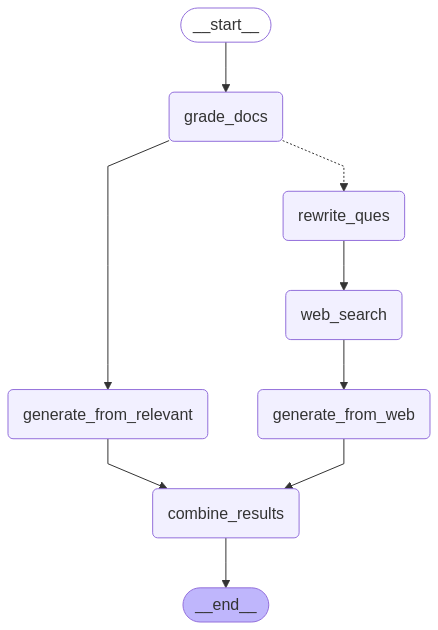

In [162]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [139]:
def run_pipeline(user_question):
    inputs = {
        "question": user_question,
        "messages": [],
    }
    for output in app.stream(inputs):
        for key, value in output.items():
            pprint(f"Node '{key}':")
            pprint(value)

In [150]:
run_pipeline("Give me news about PM Modi")

---GRADE DOCUMENTS---
Give me news about PM Modi
"Node 'grade_docs':"
{'graded_results': [{'content': '## title\n'
                                "PM's plane used Pak airspace to Saudi, "
                                'avoided it while returning after J&K attack\n'
                                '## batch_dt\n'
                                '2025-04-23\n'
                                '## desc\n'
                                "Prime Minister Narendra Modi's plane avoided "
                                'Pakistan airspace as he flew back from Jeddah '
                                'to New Delhi after cutting short his trip to '
                                'Saudi Arabia following the terror attack in '
                                "Jammu and Kashmir's Pahalgam. PM Modi "
                                'returned to Delhi on Wednesday morning after '
                                'terrorists opened fire on a group of '
                                'tourists, leav

In [167]:
from pprint import pprint

def run_pipeline(user_question):
    inputs = {
        "question": user_question,
        "messages": [],
    }
    final_state = {}
    for output in app.stream(inputs):
        # Update final_state with each node's output
        final_state.update(output)
        for key, value in output.items():
            pprint(f"Node '{key}':")
            pprint(value)

    # After streaming all nodes, print the final combined result
    if "final_output" in final_state:
        pprint("Final combined output:")
        pprint(final_state.get("final_output", []))
    else:
        pprint("No 'final_output' found in the final state")


In [168]:
run_pipeline("Give me news about PM Modi")

---GRADE DOCUMENTS---
Give me news about PM Modi
"Node 'grade_docs':"
{'graded_results': [{'content': '## title\n'
                                "PM's plane used Pak airspace to Saudi, "
                                'avoided it while returning after J&K attack\n'
                                '## batch_dt\n'
                                '2025-04-23\n'
                                '## desc\n'
                                "Prime Minister Narendra Modi's plane avoided "
                                'Pakistan airspace as he flew back from Jeddah '
                                'to New Delhi after cutting short his trip to '
                                'Saudi Arabia following the terror attack in '
                                "Jammu and Kashmir's Pahalgam. PM Modi "
                                'returned to Delhi on Wednesday morning after '
                                'terrorists opened fire on a group of '
                                'tourists, leav